<a href="https://colab.research.google.com/github/podyssea/RecommenderSystems/blob/main/RecSys_coursework_2021_2210049p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2021 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



## Setup block

Setup the data files, Python etc.

In [ ]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  3608k      0  0:00:02  0:00:02 --:--:-- 3608k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  1768k      0  0:00:01  0:00:01 --:--:-- 1768k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  4654k      0  0:00:01  0:00:01 --:--:-- 4654k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0  1032k      0  0:00:01  0:00:01 --:--:-- 1032k


In [ ]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions
SEED=42

  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-k3iuonbp/spotlight
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-k3iuonbp/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp37-none-any.whl size=34097 sha256=914964c8ac327529f4a172d5ebb42c1f2d3f82be21cd35daeecd2f46bb5aa834
  Stored in directory: /tmp/pip-ephem-wheel-cache-501eq3u_/wheels/22/6f/f1/68cc6c5b563e78737e4a8fed63ddc105a3baf25d2abccae0c6
Successfully built spotlight


# data preparation

In [ ]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [ ]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")
ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")


#stringify the id columns
def str_col(df):
  if "user_id" in df.columns:
    df["user_id"] = "u" + df.user_id.astype(str)
  if "book_id" in df.columns:
    df["book_id"] = "b" + df.book_id.astype(str)

str_col(books_df)
str_col(ratings_df)
str_col(to_read_df)
str_col(test)



# Implicit

In [ ]:
to_read_df

,Unnamed: 0,user_id,book_id
0,386014,u1333,b1797
1,36194,u765,b1797
2,25568,u1042,b1797
3,596738,u1360,b1797
4,52814,u1782,b1797
...,...,...,...
135610,444981,u556,b1157
135611,428922,u343,b1157
135612,457472,u1193,b1743
135613,487831,u1121,b1743


#explicit

In [ ]:
ratings_df

,Unnamed: 0,user_id,book_id,rating
0,0,u1,b258,5
1,130,u11,b258,3
2,1998,u143,b258,4
3,4731,u325,b258,4
4,5510,u362,b258,2
...,...,...,...,...
124757,438735,u1920,b1499,4
124758,439348,u334,b1499,2
124759,439505,u927,b1499,4
124760,439728,u1298,b1499,4


#test

In [ ]:
test

,Unnamed: 0,user_id,book_id
0,26204,u978,b323
1,74616,u109,b323
2,334583,u1721,b323
3,297262,u429,b323
4,30956,u339,b323
...,...,...,...
33912,347299,u272,b1545
33913,1881,u126,b1333
33914,400826,u1841,b1513
33915,518727,u1599,b1513


#books

In [ ]:
books_df

,Unnamed: 0,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,0,b1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,1,b2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,2,b3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,3,b4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,4,b5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,1989,b1990,11331421,11331421,6504537,83,1590514637,9.781591e+12,"Jan-Philipp Sendker, Kevin Wiliarty",2002.0,Das Herzenhören,The Art of Hearing Heartbeats,eng,3.98,41647,50338,5650,704,2697,10330,19670,16937,https://images.gr-assets.com/books/1320437247m...,https://images.gr-assets.com/books/1320437247s...
1822,1990,b1991,8935689,8935689,14366,50,1857231384,9.781857e+12,Iain M. Banks,1987.0,Consider Phlebas,"Consider Phlebas (Culture, #1)",eng,3.85,48649,53499,2666,1083,3656,12772,20533,15455,https://images.gr-assets.com/books/1327951890m...,https://images.gr-assets.com/books/1327951890s...
1823,1992,b1993,31332,31332,2925979,63,345434803,9.780345e+12,Anne Rice,1998.0,The Vampire Armand,"The Vampire Armand (The Vampire Chronicles, #6)",en-US,3.75,54919,57566,756,1129,4866,17158,18670,15743,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
1824,1996,b1997,9565548,9565548,14452295,33,054762834X,9.780548e+12,Robin LaFevers,2012.0,Grave Mercy,"Grave Mercy (His Fair Assassin, #1)",eng,3.92,70476,74683,7661,2257,4487,15591,27223,25125,https://images.gr-assets.com/books/1320269319m...,https://images.gr-assets.com/books/1320269319s...


In [ ]:
books_df.sort_values('average_rating', ascending=False).head(5)

,Unnamed: 0,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
839,861,b862,17332218,17332218,16482835,34,765326361,9.780765e+12,Brandon Sanderson,2014.0,Words of Radiance,"Words of Radiance (The Stormlight Archive, #2)",eng,4.77,73572,108176,7261,154,404,2653,18272,86693,https://images.gr-assets.com/books/1391535251m...,https://images.gr-assets.com/books/1391535251s...
420,421,b422,862041,862041,2962492,76,545044251,9.780545e+12,J.K. Rowling,1998.0,Complete Harry Potter Boxed Set,"Harry Potter Boxset (Harry Potter, #1-7)",eng,4.74,190050,204125,6508,1105,1285,7020,30666,164049,https://images.gr-assets.com/books/1392579059m...,https://images.gr-assets.com/books/1392579059s...
1243,1307,b1308,17927395,17927395,25126749,39,NaN,NaN,Sarah J. Maas,2016.0,A Court of Mist and Fury,A Court of Mist and Fury (A Court of Thorns an...,eng,4.72,108384,126491,22700,931,1420,4725,18000,101415,https://images.gr-assets.com/books/1485259138m...,https://images.gr-assets.com/books/1485259138s...
974,1009,b1010,43070,43070,2244438,26,836218051,9.780836e+12,Bill Watterson,1988.0,The Essential Calvin and Hobbes: A Calvin and ...,The Essential Calvin and Hobbes: A Calvin and ...,en-US,4.65,93001,95543,598,717,895,5387,17566,70978,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
555,561,b562,7235533,7235533,8134945,48,765326353,9.780765e+12,Brandon Sanderson,2010.0,The Way of Kings,"The Way of Kings (The Stormlight Archive, #1)",eng,4.64,144822,164477,10947,1085,1827,7661,33962,119942,https://images.gr-assets.com/books/1388184640m...,https://images.gr-assets.com/books/1388184640s...


Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [ ]:
from collections import defaultdict
from itertools import count, combinations

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)

test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(SEED))
print(validation)

num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>
<Interactions dataset (1999 users x 1826 items x 27123 interactions)>


In [ ]:
print(toread_dataset_train)

<Interactions dataset (1999 users x 1826 items x 108492 interactions)>


In [ ]:
print(num_items)

1826


#Example code

To evaluate soem of your hand-implemented recommender systems (e.g. Q1, Q4), you will need to instantiate objects that match the specification of a Spotlight model, which `mrr_score()` expects.


Here is an example recommender object that returns 0 for each item, regardless of user.

In [ ]:
from spotlight.evaluation import mrr_score, rmse_score


class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

dummymodel(num_items)

# print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



In [ ]:

#note that the latest copy of Craig's Spotlight displays a progress bar if you set verbose=True
print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2940.23it/s]

0.0


#Question 1

Non personalised baselines for ranking books based on statistics

In [ ]:
#group the ratings by book id and display only book id and rating then take the average for each book
# and pass the rating column into a list
average_rating = ratings_df[["book_id", "rating"]].groupby(["book_id"]).mean()
non_personalised_ar = average_rating['rating'].tolist()

#pass them into a similar model to dummy model and take predictions
# this process will remain the same throughout non-personalised based models
class average_rating:
  
  def __init__(self, numitems):
    self.predictions=np.ones(numitems) * non_personalised_ar
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )


#take the mrr score
print(mrr_score(average_rating(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())

1999it [00:00, 2157.63it/s]

0.0370085786108787


In [ ]:
#group by book id and display book id and rating counts from the book_df and take the sum of the ratings for each book
# and pass the rating counts into a list
number_of_ratings = books_df[["book_id", "ratings_count"]].groupby(["book_id"]).sum()
non_personalised_nor = number_of_ratings['ratings_count'].tolist()

class number_of_ratings:
  
  def __init__(self, numitems):
    self.predictions=np.ones(numitems) * non_personalised_nor
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )


print(mrr_score(number_of_ratings(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())

1999it [00:00, 2295.88it/s]

0.0458981602236436


In [ ]:
#take the number of 5 star ratings from the books df and pass them into the model
star5_ratings = books_df['ratings_5'].tolist()

class number_of_5_star_ratings:
  
  def __init__(self, numitems):
    self.predictions=np.ones(numitems) * star5_ratings
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )
    

print(mrr_score(number_of_5_star_ratings(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2280.74it/s]

0.09851435310152991


In [ ]:
#divide the number of 5 star ratings by the number of ratings for a specific item
fractions_of_ratings = np.asarray(star5_ratings) / np.asarray(non_personalised_nor)

class fractions_of_5_star:
  
  def __init__(self, numitems):
    self.predictions=np.ones(numitems) * fractions_of_ratings
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )
    

print(mrr_score(fractions_of_5_star(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())

1999it [00:00, 2222.81it/s]

0.15971513656750713


# Question 2

In [ ]:
#import necessary modules
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel
from collections import defaultdict
from itertools import count
import itertools
import time
from scipy.stats import rankdata

In [ ]:
#define the latent factors
latent_factors = [8,16,32,64]

In [ ]:
#train both the Implicit and Explicit model on the explicit dataset

##Implicit
emodel = ExplicitFactorizationModel(n_iter=5,
                                use_cuda=False,
                                random_state=np.random.RandomState(SEED) # ensure results are repeatable
)

emodel.fit(rating_dataset)

print("======== MRR For Explicit Model on Explicit Data ========================================")
print(mrr_score(emodel, test_dataset).mean())
print("=====================================================)")


##Explicit
imodel = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                  use_cuda=False,
                                  random_state=np.random.RandomState(SEED) # ensure results are repeatable
)

imodel.fit(rating_dataset)

print("======== MRR  Implicit Model on Explicit Data =========")
print(mrr_score(imodel, test_dataset).mean())
print("=====================================================)")

======== MRR For Explicit Model on Explicit Data ========================================
0.039530082501568246
=====================================================)
======== MRR  Implicit Model on Explicit Data =========
0.2213606803401701
=====================================================)


In [ ]:
#for every latent factor in the latent factor set train an implicit model and fit
# it using the explicit data validate.

#then print the MRR score for evaluation using the test dataset provided
for factor in latent_factors:
  imodel = ImplicitFactorizationModel(loss="bpr",n_iter=5,
                                      embedding_dim = factor, 
                                      use_cuda=False,
                                      random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
  
  imodel.fit(rating_dataset)

  print("Implicit Factorization Model with", factor, "latent factor")
  print("MRR Score:", mrr_score(imodel, validation).mean())
  print()

Implicit Factorization Model with 8 latent factor
MRR Score: 0.1934298498455577

Implicit Factorization Model with 16 latent factor
MRR Score: 0.21417395205539277

Implicit Factorization Model with 32 latent factor
MRR Score: 0.221480780072576

Implicit Factorization Model with 64 latent factor
MRR Score: 0.2468835608280331



In [ ]:
#train and validate which latent factor is closer to the actual model
imodel_closer_to_validation = ImplicitFactorizationModel(loss="bpr",n_iter=5,
                                      embedding_dim = 32, 
                                      use_cuda=False,
                                      random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
imodel_closer_to_validation.fit(rating_dataset)
print("MRR Score:", mrr_score(imodel_closer_to_validation, test_dataset).mean())

MRR Score: 0.2213606803401701


# Question 3 (a)

In [ ]:
#instantiate an implicit model for every latent factor in the latent factor set using the implicit dataset
# train and fit it on the implicit train set which is already defined and get the MRR score using the validation set

#get the MRR using the test dataset to evaluate
for factor in latent_factors:

  implicit_model = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                              embedding_dim=factor, 
                                              use_cuda=False, 
                                              random_state=np.random.RandomState(SEED))
  
  implicit_model.fit(toread_dataset_train)
  
  print("Implicit Factorization Model with", factor, "latent factor")
  print("MRR Score:", mrr_score(implicit_model, validation).mean())
  print()

Implicit Factorization Model with 8 latent factor
MRR Score: 0.18753583140776736

Implicit Factorization Model with 16 latent factor
MRR Score: 0.19200373996522072

Implicit Factorization Model with 32 latent factor
MRR Score: 0.18776868593026674

Implicit Factorization Model with 64 latent factor
MRR Score: 0.16480204387908243



In [ ]:
#find the best implicit model, using the validation data 
implicit_model_closer_to_validation = ImplicitFactorizationModel(loss="bpr",n_iter=5,
                                      embedding_dim = 16, 
                                      use_cuda=False,
                                      random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
implicit_model_closer_to_validation.fit(toread_dataset_train)
print("MRR Score:", mrr_score(implicit_model_closer_to_validation, test_dataset).mean())

MRR Score: 0.22662620993036198


# Question 3 (b)

In [ ]:
# here we are creating a replication of the books-df to use for this question
# we do this because we need a column renamed to item_id
books_df_replicate = books_df.copy()
books_df_replicate.rename(columns = {"Unnamed: 0" : "item_id"}, inplace = True)


In [ ]:
#define a function which takes in an item id and looks in the above created df to return the title of that item
def item_to_titles(item_ids):
  return books_df_replicate.loc[books_df_replicate["item_id"].isin(item_ids)]["title"]

#define a function which takes 3 sets of item item ids, finds the titles and returns which of them 
# are common between the first and predictions, and second and predictions
def find_common_titles(a,b, predictions):

  previously_vs_predicted = item_to_titles(np.intersect1d(a, predictions))
  print("These titles were predicted to be previously shelved correctly")
  print(previously_vs_predicted)

  currently_vs_predicted = item_to_titles(np.intersect1d(b, predictions))
  print("\n\nThese titles were predicted to be currently shelved correctly")
  print(currently_vs_predicted)
  
#define a function to get the predictions given a user id
# the function looks into the toread dataset (previously shelved) and finds the indexes of that user
# it stores the items into a list by accessing the toread dataset using those indexes - same applies for currently shelved using the test dataset and predictions
# then the function uses the find_common_titles function to return the common titles between the the previously, currently shelved and predicted
def get_predictions_for_highest_rated_user(user_id):
  item_ids_indexes_prev = np.where(toread_dataset.user_ids == user_id)
  previously_shelved = toread_dataset.item_ids[item_ids_indexes_prev]

  item_ids_indexes_curr = np.where(test_dataset.user_ids == user_id)
  currently_shelved = test_dataset.item_ids[item_ids_indexes_curr]

  predictions = implicit_model.predict(user_id)
  predicted_shelved = np.where(predictions > 0)[0]

  shelved_items = [previously_shelved, currently_shelved, predicted_shelved]

  return find_common_titles(previously_shelved, currently_shelved, predicted_shelved)

# #Train the best model in terms of MRR from Q3
# best_implicit_model = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
#                                             embedding_dim=16, 
#                                             use_cuda=False, 
#                                             random_state=np.random.RandomState(SEED))

# best_implicit_model.fit(toread_dataset_train, verbose=False)


In [ ]:
#get the mrr scores using the implicit model created above on the test dataset
mrr_scores = mrr_score(implicit_model_closer_to_validation, test_dataset)

#find the maximum of the mrr scores and the indexes at which this highest occurs in the mrr scores
m = max(mrr_scores)
indexes_of_highest = [i for i, j in enumerate(mrr_scores) if j == m]

#from the test dataset find the uids of the highest rated users
uids = test_dataset.user_ids[indexes_of_highest]

#for each uid in uids found above convert the uid to user_id using the reverse mapping
#appending to an empty list to get a list of user ids with the highest RR
index_to_user_id = []
for uid in uids:
  user_id_convert = uid_rev_map.get(uid)
  index_to_user_id.append(user_id_convert)

#print the top 5 rated uer ids
print("To 5 highest rated users are: ", index_to_user_id[:5], "with uids ", uids[:5])

To 5 highest rated users are:  ['u531', 'u305', 'u1916', 'u142', 'u809'] with uids  [11 26 31 44 52]


In [ ]:
#call the above created function to get the common titles predicted and actually shelved for each uid found
for uid in uids[:5]:
  print("Results for", uid_rev_map.get(uid))
  get_predictions_for_highest_rated_user(uid)
  print("============================================================\n\n\n")

Results for u531
These titles were predicted to be previously shelved correctly
3                                   To Kill a Mockingbird
7                                  The Catcher in the Rye
8                   Angels & Demons  (Robert Langdon, #1)
10                                        The Kite Runner
11                              Divergent (Divergent, #1)
                              ...                        
871                       Rendezvous with Rama (Rama, #1)
899                         I Am Legend and Other Stories
917               The Fires of Heaven (Wheel of Time, #5)
1009    The Perfect Storm: A True Story of Men Against...
1058    90 Minutes in Heaven: A True Story of Death an...
Name: title, Length: 80, dtype: object


These titles were predicted to be currently shelved correctly
9                                    Pride and Prejudice
23     Harry Potter and the Goblet of Fire (Harry Pot...
31                                       Of Mice and Men
34      

# Question 3c

In [ ]:
# books_df_sorted = books_df.sort_values('average_rating', ascending=False)
# books_df_sorted[:5]

In [ ]:
# top_5 = books_df_sorted[['average_rating', 'book_id']][:5]
# top_5_bookids = top_5['book_id'].tolist()
# top_5_itemids = []
# for itemid in top_5_bookids:
#   print(iid_map.get(itemid))
#   top_5_itemids.append(iid_map.get(itemid))

# top_5_itemids

In [ ]:
# top_5_embeddings = implicit_model._net.item_embeddings.weight[top_5_itemids]
# top_5_embeddings

In [ ]:
# from scipy import spatial
# similarities = []

# for combo in combinations(range(5),2):
#   i = top_5_embeddings[combo[0]].detach().numpy()
#   j = top_5_embeddings[combo[1]].detach().numpy()
#   similarities.append(1-spatial.distance.cosine(i,j))

# intra_list_div = 2/(5*4) * sum(similarities)
# print(intra_list_div)

#Question 4

In [ ]:
#create a class which will train an explicit model on the explicit and implicit data passing in the best latent factors recorded from above trained models
#fit using the training data suited for each model and allocate equal weight to both models when calling the prediction (unweighted)
class unweighted_combsum:  
  def __init__(self):
    self.explicit = self.create_train_model(rating_dataset, 32)
    self.implicit = self.create_train_model(toread_dataset_train, 16)
 
  def create_train_model(self, train_dataset, latent):
    model = ImplicitFactorizationModel(n_iter = 5, loss = "bpr", random_state=np.random.RandomState(SEED), embedding_dim = latent)
    model.fit(train_dataset)
    return model

  def predict(self, uid):
    # returns the combined rating
    return 0.5 * self.explicit.predict(uid) + 0.5 * self.implicit.predict(uid)

In [ ]:
#call the models in a variable
q4 = unweighted_combsum()

In [ ]:
#get the MRR scores of the model
q4_mrr_scores = mrr_score(q4, test_dataset)

In [ ]:
q4_mrr_scores

array([0.        , 0.33333333, 0.        , ..., 0.11111111, 0.        ,
       0.        ])

In [ ]:
#best model from q2
best_implicit_q2 = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)

best_implicit_q2.fit(rating_dataset)

q2_mrr_scores = mrr_score(best_implicit_q2, test_dataset)
print("======== MRR ========= for latent factor 32")
print("=====================================================)")
print(mrr_score(best_implicit_q2, test_dataset).mean())
print("=====================================================)")

======== MRR ========= for latent factor 32
=====================================================)
0.2213606803401701
=====================================================)


In [ ]:
#best model from q3
best_implicit_q3 = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                            embedding_dim=16, 
                                            use_cuda=False, 
                                            random_state=np.random.RandomState(SEED))

best_implicit_q3.fit(toread_dataset_train)

q3_mrr_scores = mrr_score(best_implicit_q3, test_dataset)
print("======== MRR ========= for latent factor 16")
print("=====================================================)")
print(mrr_score(best_implicit_q3, test_dataset).mean())
print("=====================================================)")

======== MRR ========= for latent factor 16
=====================================================)
0.22662620993036198
=====================================================)


In [ ]:
import matplotlib.pyplot as plt

#calculate the differences in the scores calucated in q2 and q3 individually to find out how many RR scores changed
diff_q2_q4 = q4_mrr_scores - q2_mrr_scores # <------best
diff_q3_q4 = q4_mrr_scores - q3_mrr_scores

print("\n=========== FROM Q2 ==========")
print(sum(i > 0 for i in diff_q2_q4), "are better")
print(sum(i < 0 for i in diff_q2_q4), "are worse")
print(sum(i == 0 for i in diff_q2_q4), "have not changed")

print("\n=========== FROM Q3 ==========")
print(sum(i > 0 for i in diff_q3_q4), "are better")
print(sum(i < 0 for i in diff_q3_q4), "are worse")
print(sum(i == 0 for i in diff_q3_q4), "have not changed")


=========== FROM Q2 ==========
631 are better
483 are worse
885 have not changed

=========== FROM Q3 ==========
601 are better
554 are worse
844 have not changed


In [ ]:
#Create a dataframe that has the item ids, the previous RR and the RR obtained from the combsum model we created
## we create another column named diff to pass in the difference
data = {'item_ids' : uid_map.keys(), 'Previous RR': q3_mrr_scores, 'New RR': q4_mrr_scores}  
RR_df = pd.DataFrame(data) 
RR_df["diff"] = RR_df['New RR'] - RR_df['Previous RR']
RR_df = RR_df[RR_df['diff'] != 0]
RR_df

,item_ids,Previous RR,New RR,diff
1,u109,0.000000,0.333333,0.333333
3,u429,0.142857,0.333333,0.190476
4,u339,0.333333,0.250000,-0.083333
5,u302,0.333333,0.142857,-0.190476
9,u1330,0.125000,0.200000,0.075000
...,...,...,...,...
1989,u1948,0.500000,0.000000,-0.500000
1992,u1854,0.000000,0.250000,0.250000
1993,u1142,1.000000,0.250000,-0.750000
1994,u1045,0.250000,0.333333,0.083333


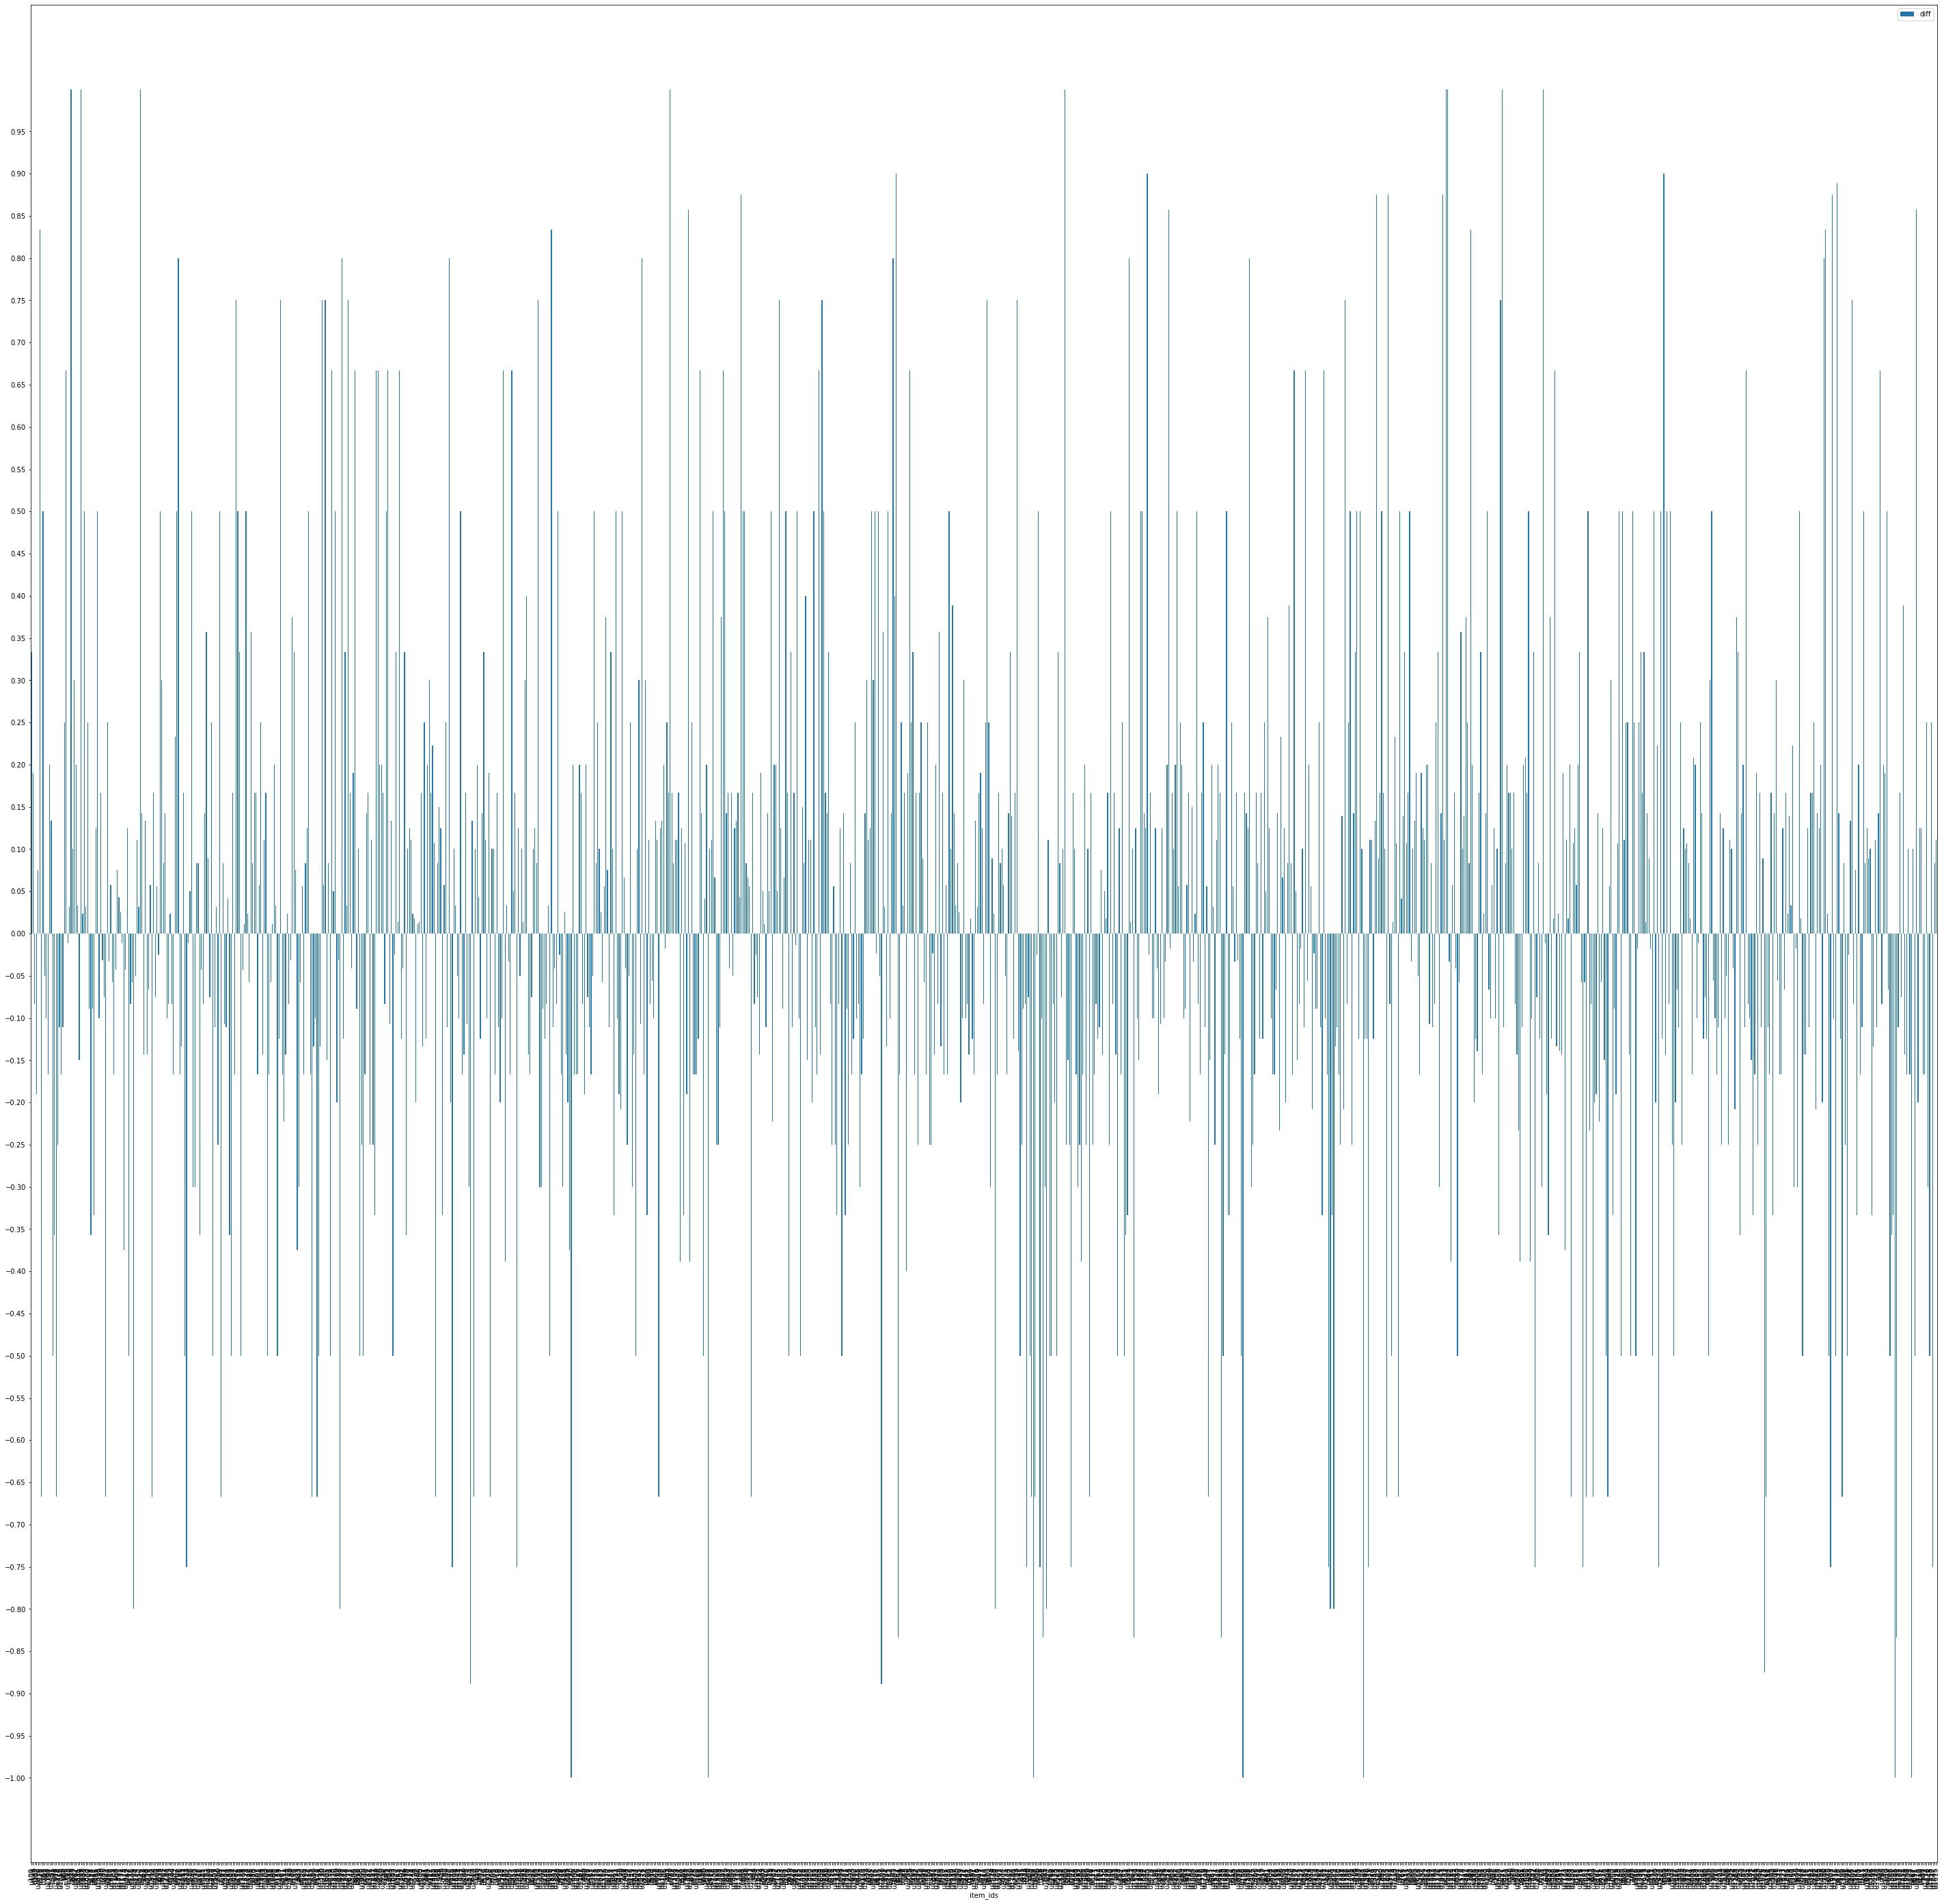

In [ ]:
#we plot a bar chart of the old RR and the new RR for each user
RR_df.plot(x ='item_ids', y='diff', kind = 'bar', figsize=(50,50))
y_ticks = np.arange(-1, 1, 0.05)
plt.yticks(y_ticks)
plt.xticks(rotation=90)
plt.show()

# Question 5

In [ ]:
## Referenced from RecSys - Lab 1 Solution
def calculate_lift():
  positives=ratings_df[ratings_df["rating"]>=4]
  positives

  # #join positives with itself on userId to get all pairs of books watched by a given user.

  pairs=pd.merge(positives, positives, on=["user_id"])
  pairs

  # #we dont care either A->B, or B->A
  sequences=pairs[pairs['Unnamed: 0_x'] < pairs['Unnamed: 0_y']] 
  sequences

  # #lets count the frequency of each pair of books
  paircounts=sequences[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()
  paircounts

  #sort by the most popular pairs.
  pairswithcounts_reset = paircounts.reset_index()
  pairswithcounts = pairswithcounts_reset.rename(columns={'user_id' : 'count'}).sort_values(['count'], ascending=False)
  pairswithcounts.head()

  pairswithcounts.merge(books_df, left_on=["book_id_x"], right_on="book_id").merge(books_df, left_on=["book_id_y"], right_on="book_id")[["title_x", "title_y"]]

  # # pairswithcounts gives is the frequency of (X AND Y). 

  # #We therefore need the counts of books
  bookCounts = positives.groupby(['book_id']).count()[['user_id']].reset_index().rename(columns={'user_id' : 'count'})
  bookCounts

  # #lets puts all the information in the sample dataframe.
  allstats = pairswithcounts.merge(bookCounts, left_on='book_id_x', right_on='book_id').merge(bookCounts, left_on='book_id_y', right_on='book_id')
  allstats

  # #and drop out some unused columns
  allstats = allstats[['book_id_x', 'book_id_y', 'count', 'count_x', 'count_y']]
  allstats

  allstats = allstats.loc[:,~allstats.columns.duplicated()]
  allstats

  # #to calculate probabilites we need a denominator. I used the number of total ratings
  num=float(ratings_df.count()["rating"])

  # #we can then perform artihmetic on columns
  allstats["lift"] = (allstats["count"] / num ) / ( (allstats["count_x"] / num) * (allstats["count_y"] / num))
  allstats["loglift"] = np.log(allstats["lift"])

  withtitles = allstats.merge(books_df, left_on=['book_id_x'],  right_on="book_id").merge(books_df, left_on=["book_id_y"], right_on="book_id")
  withtitles


  #we add the support column
  withtitles["support"] = withtitles["count"] / sequences["book_id_x"].count()

  #select the columns we want to see
  withtitles[["title_x", "book_id_x", "book_id_y", "lift", "support"]]
  final = withtitles[["title_y", "title_x", "book_id_x", "book_id_y", "lift", "support", "count", "loglift"]]

  #remove the duplicates from the dataframe
  final = final.loc[:,~final.columns.duplicated()]
  return final

In [ ]:
#display tha dataframe
calculate_lift()

,title_y,title_x,book_id_x,book_id_y,lift,support,count,loglift
0,"Catching Fire (The Hunger Games, #2)","The Hunger Games (The Hunger Games, #1)",b1,b17,364.310869,1.999159e-04,365,5.898008
1,"Catching Fire (The Hunger Games, #2)",Harry Potter and the Sorcerer's Stone (Harry P...,b2,b17,1678.391936,1.999159e-04,365,7.425591
2,"Catching Fire (The Hunger Games, #2)",Harry Potter and the Goblet of Fire (Harry Pot...,b24,b17,1912.241959,1.999159e-04,365,7.556032
3,"Catching Fire (The Hunger Games, #2)",Harry Potter and the Half-Blood Prince (Harry ...,b27,b17,1474.298433,1.999159e-04,365,7.295938
4,"Catching Fire (The Hunger Games, #2)",Harry Potter and the Prisoner of Azkaban (Harr...,b18,b17,1527.715043,1.999159e-04,365,7.331528
...,...,...,...,...,...,...,...,...
721164,"Piercing the Darkness (Darkness, #2)",Nights in Rodanthe,b622,b1925,17823.142857,5.477147e-07,1,9.788253
721165,"Piercing the Darkness (Darkness, #2)","This Present Darkness (Darkness, #1)",b1218,b1925,17823.142857,5.477147e-07,1,9.788253
721166,"Piercing the Darkness (Darkness, #2)","At First Sight (Jeremy Marsh & Lexie Darnell, #2)",b1459,b1925,20793.666667,5.477147e-07,1,9.942404
721167,"Gone (Gone, #1)",The Absolutely True Diary of a Part-Time Indian,b591,b685,1919.415385,5.477147e-07,1,7.559776


In [ ]:
#create the loglift class where we set a minimum support which we will use to evaluate
#this minimum support will filter the dataframe and calculate the according lift scores
class loglift:
  def __init__(self, min_sup = 0):
    self.minimum_support = min_sup
    self.df = lifts.loc[(lifts["support"] > self.minimum_support)]
    self.book_ids = books_df["book_id"].values
    self.book_lift_scores = self.calculate_book_lift_scores()
 
  #use this function to calculate the book lift for the given books
  def calculate_book_lift_scores(self): 
    return np.array([self.df.loc[(self.df["book_id_x"] == bookid) | (self.df["book_id_y"] == bookid)]["loglift"].values.sum() for bookid in self.book_ids])
 
  #call the predictions
  def predict(self, uid):
    userid = uid_rev_map[uid]
    scores = []
    scores = np.zeros(1826)

    #for books that are not already rated
    already_rated_books = ratings_df.loc[ratings_df["user_id"] == userid]["book_id"].values

    #get the indices of the books that are not already rated
    lift_indices = np.array([i for i  in range(len(self.book_ids)) if self.book_ids[i] not in already_rated_books])\

    #calculate the scores for these books
    scores[lift_indices] = self.book_lift_scores[lift_indices]

    return scores

In [ ]:
#pass the lift dataframe in a variable
lifts = calculate_lift()

In [ ]:
#initialize an empty list
q5_mrr_scores =  []

#get 10 values of minimum support between minimum and maximum to experiment
min_supports = np.linspace(lifts["support"].min(), lifts["support"].max(), 10)

#using the minimum support on the loglift recommender, append the MRR score calculated
for min_support in min_supports:
  q5_mrr_scores.append(mrr_score(loglift(min_support), validation))

In [ ]:
#get the mean MRR for each minimum support calculated from above
## this will be used for plotting
mean_RR = []
for each in q5_mrr_scores:
  mean_RR.append(each.mean())

print(mean_RR)
print(min_supports)

[0.07603543835409768, 0.05580012228336391, 0.05725779556444889, 0.05790534155966872, 0.057036851759212935, 0.06443162057219086, 0.08278440094611339, 0.054070487624764754, 0.03266216441554111, 0.0]
[5.47714715e-07 3.26194541e-05 6.46911936e-05 9.67629330e-05
 1.28834672e-04 1.60906412e-04 1.92978151e-04 2.25049891e-04
 2.57121630e-04 2.89193370e-04]


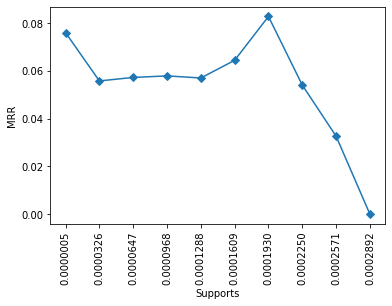

In [ ]:
#plot the minimum support against the mean RR of each support to see how MRR behaves
plt.plot(min_supports, mean_RR, marker = 'D')
plt.xticks(min_supports, rotation = 90)
plt.xlabel('Supports')
plt.ylabel('MRR')

## store the best minimum support 
best_min_support = min_supports[np.argmax(mean_RR)]

In [ ]:
print(mrr_score(loglift(best_min_support), test_dataset).mean())

0.09883937505379806


# Question 6

In [ ]:
## initiliase and train recommenders
class initiliase_recommenders:
  def __init__(self):
    ## ===========================================Low Group========================================
    self.average_rating = average_rating(num_items)
    self.number_of_ratings = number_of_ratings(num_items)  
    self.emodel = ExplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(SEED))
    ## =========================================================================================
 
    ## ========================================== High Group ====================================== 
    self.number_of_5_star_ratings = number_of_5_star_ratings(num_items)
    self.loglift = loglift(best_min_support)
    self.fractions_of_5_star = fractions_of_5_star(num_items)

    ## ===========================================Two Best======================================
    self.imodel = ImplicitFactorizationModel(n_iter = 5, loss = "bpr", random_state=np.random.RandomState(SEED), embedding_dim = 32)
    self.best_implicit_model = ImplicitFactorizationModel(n_iter = 5, loss = "bpr", random_state=np.random.RandomState(SEED), embedding_dim = 16)
    ## =========================================================================================


    # call train function
    self.train_models()
 

    #iterate over the recommender list
    self.recommender_list = self.iterate_over()
 
  #train them
  def train_models(self):
    self.emodel.fit(rating_dataset)
    self.imodel.fit(rating_dataset)
    self.best_implicit_model.fit(toread_dataset_train)
 
  #iterate over the recommenders and assigns a value to each one
  def iterate_over(self):
    recommenders = []
    for attr, value in self.__dict__.items():
          recommenders.append(value)
    return recommenders

In [ ]:
#this class combines all the recommenders and takes in a list of weights for bias
class combine_recommenders:
  def __init__(self, recommenders, weights = []):
    self.recommenders = recommenders
    self.number_of_recommenders = len(recommenders)

    #if we give a weights list equal to recommenders set weights equal to that list
    ## else assign an equal weight to the recommender 1/number of recommenders to be equal to 1
    if len(weights) == self.number_of_recommenders:
      self.weights = weights
    else:
      self.weights = np.ones(self.number_of_recommenders) * 1/self.number_of_recommenders

  #call predictions
  def predict(self, uid):
    predictions = 0
    for rec in range(self.number_of_recommenders):
      predictions += self.recommenders[rec].predict(uid) * self.weights[rec]
    return predictions

In [ ]:
#define a function that returns the weights based on the bias set, returns changed weight list
def calculate_bias_weight(bias,indexes):
  weights = np.ones(8) * (1-bias*len(indexes))/(8-len(indexes))
  for i in indexes:
    weights[i] = bias
  return weights

In [ ]:
#initialise the recommenders
trained_recommenders = initiliase_recommenders()

#Get Weights for different Bias Values

In [ ]:
#assing equal weights to all recommenders of 1/number of recommenders
no_of_recommenders = 8
weights_list_without_bias = []
recommender_indices = list(range(no_of_recommenders))
weights_list_without_bias.append(np.ones(no_of_recommenders) * 1/no_of_recommenders)

#assign a bias of 0.3 one recommender each time in turn while experimenting
bias_test = 0.3
weights_list_with_bias = []
for i in range(no_of_recommenders):
  weights_list_with_bias.append(calculate_bias_weight(bias_test, [i]))

#assing bias to the highest performing group of models
highest_group_equal_weights = []
for bias in [0.15, 0.17]:
  highest_group_equal_weights.append(calculate_bias_weight(bias, recommender_indices[3:]))

#assign bias to the two best performing models
two_highest_rec_equal_weights = []
for bias in [0.2,0.3,0.4]:
  two_highest_rec_equal_weights.append(calculate_bias_weight(bias, recommender_indices[6:]))

#Get MRR Scores for those Bias Values in order set above

In [ ]:
#get MRR without bias
q6_mrr_scores_without_bias = mrr_score(combine_recommenders(trained_recommenders.rec_list, weights_list_without_bias), validation).mean()
print(q6_mrr_scores_without_bias)

In [ ]:
#get MRR for weight with bias
q6_mmr_scores_with_bias = []
for each in weights_list_with_bias:
  q6_mmr_scores_with_bias.append(mrr_score(combine_recommenders(trained_recommenders.rec_list, each), validation).mean())
print(q6_mmr_scores_with_bias)

In [ ]:
#get MRR with equal bias on the best performing group
q6_mmr_scores_highest_group_equal_weights = []
for each in highest_group_equal_weights:
  q6_mmr_scores_highest_group_equal_weights.append(mrr_score(combine_recommenders(trained_recommenders.rec_list, each), validation).mean())
print(q6_mmr_scores_highest_group_equal_weights)

In [ ]:
#get MRR with bias on top two models
q6_mmr_scores_two_highest_rec_equal_weights = []
for each in two_highest_rec_equal_weights:
  q6_mmr_scores_two_highest_rec_equal_weights.append(mrr_score(combine_recommenders(trained_recommenders.rec_list, each), validation).mean())
print(q6_mmr_scores_two_highest_rec_equal_weights)

#Get Graph

In [ ]:
#flatten the list of MRR scores to prepare data for plotting
flattened_list = []
flattened_list.append(q6_mrr_scores_without_bias)

for each in q6_mmr_scores_with_point3_bias:
  flattened_list.append(each)

for each in q6_mmr_scores_highest_group_equal_weights:
  flattened_list.append(each)

for each in q6_mmr_scores_two_highest_rec_equal_weights:
  flattened_list.append(each)

Text(0.5, 1.0, 'MRR/Bias Experiment')

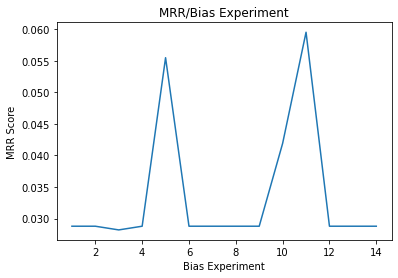

In [ ]:
#Plot the graph of the MRR against experiment
plt.plot(range(1,15), flattened_list)
plt.ylabel('MRR Score')
plt.xlabel('Bias Experiment')
plt.title('MRR/Bias Experiment')
